# Version description
- 3 class
- Full run
- Normal feats

In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc
import seaborn as sns
import scipy.cluster.hierarchy as spc

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import ndcg_score, accuracy_score, mean_squared_error

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
Notebook Parameters
'''
# basic
MODEL = 'clf3'
FE_PATH = '../input/jpx-feature-engineering-v13/features'
SEED = 0
SEEDS = [1,2,3,4,5]
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'
EXTRA_VAL_DATE_START = None

# data sacling
SCALER = StandardScaler()
SCALE_DAILY = False

# drop market features
DROP_MARKET_FEATS = False

# PCA
RUN_PCA = False
PCA_SPLIT = True
N_COMP = 0.9

# target definition
RANK_ASCENDING = False # set this to False if model prediction is same direction of Target

# data split
N_FOLD = 5
TRN_SIZE = 240
VAL_SIZE = 60
TRN_VAL_GAP = 14
SPLIT_METHOD = 'trn_val_split_late_val'

# model fixed params
DEVICE_TYPE = 'CPU'
if MODEL=='reg':
    EVAL_METRIC, OBJECTIVE = 'rmse', 'rmse'
elif MODEL=='clf':
    EVAL_METRIC, OBJECTIVE = 'binary_logloss', 'binary'
elif MODEL=='clf3':
    EVAL_METRIC, OBJECTIVE = 'multi_logloss', 'multiclass'
LGBM_VAR_PARAMS = dict(
    max_depth = 32,
    num_leaves = 32,
    learning_rate = 0.05,
    min_child_weight = 0.1,
    min_child_samples = 1,
    subsample = 0.65,
    subsample_freq = 1,
    colsample_bytree = 0.6,
    reg_alpha = 1.5,
    reg_lambda = 1.5,
    max_bin = 255,
)
LGBM_FIXED_PARAMS = dict(
    boosting_type = 'gbdt',
    objective = OBJECTIVE,
    n_estimators = 5000,
    n_jobs = -1,
    random_state = SEED,
    device_type = DEVICE_TYPE,
)

# feature importance
RUN_IMP = True
N_SHUFFLE = 5
N_FEATS_IMP_TEST = 10
N_ESTIMATORS_IMP = 50
EARLY_STOPPING_ROUNDS_IMP = 9999
FEAT_GROUPS = None # fixed output if not running IMP

# forward selection
RUN_FS = True
FS_SPLIT = {'n_stock_feats': 14, 'n_market_feats': 5}
SELECTED_STOCK_FEATS = None
N_ESTIMATORS_FS = 5000
EARLY_STOPPING_ROUNDS_FS = 20
N_FEATS_FS = None # top N features considered for FS based on importance
N_FEATS_FINAL = None # top N features if skipping FS based on importance
SELECTED_FEATS = ''.split(', ') # fixed features if skipping both IMP and FS

# hyperparameters tuning
RUN_HP = True
N_ESTIMATORS_HP = 5000
EARLY_STOPPING_ROUNDS_HP = 30
HP_OPT_HRS = 4
BEST_PARAMS = None

# re-fit
N_ESTIMATORS_REFIT = 5000
EARLY_STOPPING_ROUNDS_REFIT = 30

# optimization
USE_VAL_FULL = True
CLUSTER_DEMEAN = True
CLUST_N_DAY = 60
VOL_PENALTY = True
VOL_N_DAY = 60
VOL_POW = 1

# Data preprocessing

In [3]:
'''
Train-Val split where validation periods are right after train period
'''
def trn_val_split_even_val(features, val_to_end):
    # separate normal and extra data
    if EXTRA_VAL_DATE_START!=None:
        features, features_extra = features.loc[lambda x: x.Date<EXTRA_VAL_DATE_START].reset_index(drop=True), features.loc[lambda x: x.Date>=EXTRA_VAL_DATE_START].reset_index(drop=True)
    
    # define start date of each fold
    fold_dates = features.Date.drop_duplicates().reset_index(drop=True)
    fold_dates = fold_dates.shift(TRN_SIZE + TRN_VAL_GAP + VAL_SIZE).loc[lambda x: x.notnull()].reset_index(drop=True)
    fold_dates = fold_dates.loc[np.linspace(0, fold_dates.shape[0]-1, N_FOLD).astype(int)].reset_index(drop=True)

    # create and append train + val data
    full_dates = features.Date.drop_duplicates().reset_index(drop=True)
    full_data = []
    for i, date in enumerate(fold_dates):
        dates_trn = full_dates.loc[lambda x: x>=date].head(TRN_SIZE)
        if val_to_end==False:
            dates_val = full_dates.loc[lambda x: x>=date].shift(-TRN_SIZE).shift(-TRN_VAL_GAP).head(VAL_SIZE)
        else:
            dates_val = full_dates.loc[lambda x: x>=date].shift(-TRN_SIZE).shift(-TRN_VAL_GAP).loc[lambda x: x.notnull()]
        full_data.append(features.loc[lambda x: x.Date.isin(dates_trn)].assign(fold=i, trn_val='trn'))
        full_data.append(features.loc[lambda x: x.Date.isin(dates_val)].assign(fold=i, trn_val='val'))
    
    # add back extra data
    if EXTRA_VAL_DATE_START!=None:
        full_data.append(features_extra.assign(fold=N_FOLD, trn_val='val'))
    full_data = pd.concat(full_data).reset_index(drop=True)
    return full_data


'''
Train-Val split where validation periods are farthest in future
'''
def trn_val_split_late_val(features, val_to_end):
    # separate normal and extra data
    if EXTRA_VAL_DATE_START!=None:
        features, features_extra = features.loc[lambda x: x.Date<EXTRA_VAL_DATE_START].reset_index(drop=True), features.loc[lambda x: x.Date>=EXTRA_VAL_DATE_START].reset_index(drop=True)
    
    # define start date of each fold
    fold_dates = features.Date.drop_duplicates().reset_index(drop=True)
    fold_dates = fold_dates.shift(TRN_SIZE + TRN_VAL_GAP + VAL_SIZE).loc[lambda x: x.notnull()].reset_index(drop=True)
    fold_dates = fold_dates.loc[np.linspace(0, fold_dates.shape[0]-1, N_FOLD).astype(int)].reset_index(drop=True)

    # create and append train + val data
    full_dates = features.Date.drop_duplicates().reset_index(drop=True)
    val_dates_list = full_dates.tail(VAL_SIZE * N_FOLD).values.reshape(N_FOLD, -1)
    full_data = []
    for i, date in enumerate(fold_dates):
        dates_trn = full_dates.loc[lambda x: x>=date].head(TRN_SIZE)
        if val_to_end==False:
            dates_val = val_dates_list[i]
        else:
            dates_val = np.concatenate(val_dates_list[i:])
        full_data.append(features.loc[lambda x: x.Date.isin(dates_trn)].assign(fold=i, trn_val='trn'))
        full_data.append(features.loc[lambda x: x.Date.isin(dates_val)].assign(fold=i, trn_val='val'))
        
    # add back extra data
    if EXTRA_VAL_DATE_START!=None:
        full_data.append(features_extra.assign(fold=N_FOLD, trn_val='val'))
    full_data = pd.concat(full_data).reset_index(drop=True)
    return full_data

In [4]:
'''
Function to scale the features
'''
def jpx_data_scaling(full_data, scaler, daily):
    feats = time_features + stock_features
    
    if daily==False:
        data_scaled = []
        for fold in range(N_FOLD):
            # locate train and val datasets
            data_trn = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')]
            data_val = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')]
            # fit scaler
            scaler = scaler.fit(data_trn[feats])
            save_pkl(scaler, f'scaler{fold}')
            # transform data
            data_trn[feats] = scaler.transform(data_trn[feats]).astype(np.float32)
            data_val[feats] = scaler.transform(data_val[feats]).astype(np.float32)
            # store transformed data
            data_scaled.append(data_trn)
            data_scaled.append(data_val)
        # also transform the extra data, using last fold scaler
        if EXTRA_VAL_DATE_START!=None:
            data_val = full_data.loc[lambda x: (x.fold==N_FOLD) & (x.trn_val=='val')]
            data_val[feats] = scaler.transform(data_val[feats]).astype(np.float32)
            data_scaled.append(data_val)
        data_scaled = pd.concat(data_scaled).reset_index(drop=True)
            
    elif daily==True:
        # scale stock features for each day
        def transform_data(df, scaler, feats):
            df[feats] = scaler.fit_transform(df[feats]).astype(np.float32)
            return df
        full_data = full_data.groupby(['fold','trn_val','Date']).apply(lambda df: transform_data(df, scaler, stock_features))
        # then scale time features across days
        data_scaled = []
        for fold in range(N_FOLD):
            # locate train and val datasets
            data_trn = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')]
            data_val = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')]
            # fit scaler
            scaler = scaler.fit(data_trn[time_features])
            save_pkl(scaler, f'scaler{fold}')
            # transform data
            data_trn[time_features] = scaler.transform(data_trn[time_features]).astype(np.float32)
            data_val[time_features] = scaler.transform(data_val[time_features]).astype(np.float32)
            # store transformed data
            data_scaled.append(data_trn)
            data_scaled.append(data_val)
        # also transform the extra data, using last fold scaler
        if EXTRA_VAL_DATE_START!=None:
            data_val = full_data.loc[lambda x: (x.fold==N_FOLD) & (x.trn_val=='val')]
            data_val[feats] = scaler.transform(data_val[feats]).astype(np.float32)
            data_scaled.append(data_val)
        data_scaled = pd.concat(data_scaled).reset_index(drop=True)
        
    return data_scaled

In [5]:
'''
PCA Compression
'''
def pca_compress(full_data):
    
    if PCA_SPLIT==False:
        # fit with one fold of traiing data
        pca = PCA(n_components=N_COMP, random_state=SEED)
        pca.fit(full_data.loc[lambda x: (x.fold==0) & (x.trn_val=='trn'), all_features])
        save_pkl(pca, 'pca')
        log(f'PCA shape of components: {pca.components_.shape}')
        
        # tranform the full dataset
        cols = [f'pc{x}' for x in range(pca.components_.shape[0])]
        compressed_data = []
        if EXTRA_VAL_DATE_START!=None:
            iter_list = list(itertools.product(range(N_FOLD), ['trn','val'])) + [(N_FOLD, 'val')]
        else:
            iter_list = list(itertools.product(range(N_FOLD), ['trn','val']))
        for fold, trn_val in iter_list:
            X = pd.DataFrame(pca.transform(full_data.loc[lambda x: (x.fold==fold) & (x.trn_val==trn_val), all_features]), columns=cols)
            header = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val==trn_val), [c for c in full_data.columns if c not in all_features]].reset_index(drop=True)
            new_df = pd.concat([header, X], axis=1)
            compressed_data.append(new_df)
        compressed_data = pd.concat(compressed_data, axis=0).reset_index(drop=True)
        col_def = {'all_features': cols,
                   'stock_features': None,
                   'time_features': None}
        
    elif PCA_SPLIT==True:
        # fit with one fold of traiing data
        stock_feats = [c for c in all_features if c not in time_features]
        market_feats = [c for c in all_features if c in time_features]
        pca_stock = PCA(n_components=N_COMP, random_state=SEED)
        pca_market = PCA(n_components=N_COMP, random_state=SEED)
        pca_stock.fit(full_data.loc[lambda x: (x.fold==0) & (x.trn_val=='trn'), stock_feats])
        pca_market.fit(full_data.loc[lambda x: (x.fold==0) & (x.trn_val=='trn'), market_feats])
        save_pkl(pca_stock, 'pca_stock')
        save_pkl(pca_market, 'pca_market')
        log(f'Stock PCA shape of components: {pca_stock.components_.shape}')
        log(f'Market PCA shape of components: {pca_market.components_.shape}')
    
        # tranform the full dataset
        cols_stock = [f'pc_stock{x}' for x in range(pca_stock.components_.shape[0])]
        cols_market = [f'pc_market{x}' for x in range(pca_market.components_.shape[0])]
        compressed_data = []
        if EXTRA_VAL_DATE_START!=None:
            iter_list = list(itertools.product(range(N_FOLD), ['trn','val'])) + [(N_FOLD, 'val')]
        else:
            iter_list = list(itertools.product(range(N_FOLD), ['trn','val']))
        for fold, trn_val in iter_list:
            X_stock = pd.DataFrame(pca_stock.transform(full_data.loc[lambda x: (x.fold==fold) & (x.trn_val==trn_val), stock_feats]), columns=cols_stock)
            X_market = pd.DataFrame(pca_market.transform(full_data.loc[lambda x: (x.fold==fold) & (x.trn_val==trn_val), market_feats]), columns=cols_market)
            header = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val==trn_val), [c for c in full_data.columns if c not in all_features]].reset_index(drop=True)
            new_df = pd.concat([header, X_stock, X_market], axis=1)
            compressed_data.append(new_df)
        compressed_data = pd.concat(compressed_data, axis=0).reset_index(drop=True)
        col_def = {'all_features': cols_stock + cols_market,
                   'stock_features': cols_stock,
                   'time_features': cols_market}
    return compressed_data, col_def

# Model Training Functions

In [6]:
'''
Function to get sub-columns from table for model fitting
'''
def get_dataset(df, selected_feats, trn_val):
    if trn_val=='val':
        df = df.groupby('Date').sample(frac=1.0, random_state=SEED)
    df = df.reset_index(drop=True)
    grp = df.groupby('Date').size().tolist()
    qid = df['Date']
    X = df[selected_feats]
    y = df['target_train']
    target = df['Target']
    header = df[id_cols]
    return X, y, grp, qid, header, target

'''
Function to predict scores within groups
'''
def pred_score(model, X):
    if MODEL=='reg':
        return pd.Series(model.predict(X))
    elif MODEL=='clf':
        return pd.Series(model.predict_proba(X)[:,1])
    elif MODEL=='clf3':
        return pd.Series((model.predict_proba(X) * [-1,0,1]).sum(axis=1))


'''
Function to transform model output to rank prediction table
'''
def get_pred_df(header, pred_model, y_true_train, y_true, rank_ascending):
    df_pred = pd.concat([header[['RowId','Date','SecuritiesCode']].assign(Date=lambda x: x.Date.dt.strftime('%Y-%m-%d'), SecuritiesCode=lambda x: x.SecuritiesCode.astype(int)).reset_index(drop=True),
                        pd.Series(pred_model).rename('pred_model').reset_index(drop=True),
                        y_true_train.reset_index(drop=True),
                        y_true.reset_index(drop=True)
                        ], axis=1)
    df_pred['Rank'] = df_pred.groupby('Date').pred_model.rank(method='first', ascending=rank_ascending).astype(int) - 1
    return df_pred

'''
Official function to calculate Sharpe Ratio given a prediction
'''
def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def my_calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return pd.DataFrame({'long':[purchase],'short':[short],'net':[purchase - short]})

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [7]:
'''
Training function
'''
def train_model(fold, params, mode):
    # unpack model params
    selected_feats = params['selected_feats']
    lgbm_var_params = params['lgbm_var_params']
    lgbm_fixed_params = params['lgbm_fixed_params']
    lgbm_fixed_params['n_estimators'] = params['n_estimators']
    early_stopping_rounds = params['early_stopping_rounds']
    
    # define dataset
    data_trn = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')]
    data_val = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')]
    data_val_full = full_data.loc[lambda x: (x.fold>=fold) & (x.trn_val=='val')]
    X_trn, y_trn, grp_trn, qid_trn, header_trn, target_trn = get_dataset(data_trn, selected_feats, 'trn')
    X_val, y_val, grp_val, qid_val, header_val, target_val = get_dataset(data_val, selected_feats, 'val')
    X_val_full, y_val_full, grp_val_full, qid_val_full, header_val_full, target_val_full = get_dataset(data_val_full, selected_feats, 'val')
    # model fit
    if MODEL=='reg':
        model = lgbm.LGBMRegressor(**lgbm_fixed_params, **lgbm_var_params)
    elif MODEL=='clf':
        model = lgbm.LGBMClassifier(**lgbm_fixed_params, **lgbm_var_params)
    elif MODEL=='clf3':
        model = lgbm.LGBMClassifier(**lgbm_fixed_params, **lgbm_var_params)
    model.fit(
        X = X_trn,
        y = y_trn,
        eval_set = [(X_val, y_val)],
        eval_names = ['Validation'],
        verbose = False,
        eval_metric = EVAL_METRIC,
        early_stopping_rounds = early_stopping_rounds
    )

    # output
    if mode == 'val_score_only':
        output = model.best_score_['Validation'][EVAL_METRIC] # this score is for minimization problem
        
    if mode == 'val_sharpe_only':
        pred_val = pred_score(model, X_val)
        df_pred_val = get_pred_df(header_val, pred_val, y_val, target_val, RANK_ASCENDING)
        sharpe_val = calc_spread_return_sharpe(df_pred_val)
        output = sharpe_val * -1 # this score is for minimization problem
        
    if mode == 'feat_imp':
        model.set_params(importance_type='gain')
        imp_gain = model.feature_importances_
        model.set_params(importance_type='split')
        imp_split = model.feature_importances_
        output = pd.concat([
            pd.DataFrame({'feat':model.feature_name_, 'imp':imp_gain}).assign(imp_type='gain', imp=lambda x: x.imp.rank()),
            pd.DataFrame({'feat':model.feature_name_, 'imp':imp_split}).assign(imp_type='split', imp=lambda x: x.imp.rank())
        ], axis=0).assign(fold=fold)
    
    if mode == 'normal':
        # save model
        save_pkl(model, f"model{fold}_seed{SEED}")
        # number of distinct predicted values
        n_uniq_trn = pd.concat([pred_score(model, X_trn).rename('score'), header_trn], axis=1).groupby('Date').score.nunique().mean()
        n_uniq_val = pd.concat([pred_score(model, X_val).rename('score'), header_val], axis=1).groupby('Date').score.nunique().mean()
        # prediction
        pred_trn = pred_score(model, X_trn)
        pred_val = pred_score(model, X_val)
        pred_val_full = pred_score(model, X_val_full)
        # prediction df
        df_pred_trn = get_pred_df(header_trn, pred_trn, y_trn, target_trn, RANK_ASCENDING)
        df_pred_val = get_pred_df(header_val, pred_val, y_val, target_val, RANK_ASCENDING)
        df_pred_val_full = get_pred_df(header_val_full, pred_val_full, y_val_full, target_val_full, RANK_ASCENDING)
        # sharpe
        sharpe_trn = calc_spread_return_sharpe(df_pred_trn)
        sharpe_val = calc_spread_return_sharpe(df_pred_val)
        sharpe_val_full = calc_spread_return_sharpe(df_pred_val_full)
        # output dict
        output = dict(
            fold = fold,
            params = params,
            best_iteration_ = model.best_iteration_,
            best_score_ = model.best_score_['Validation'][EVAL_METRIC],
            sharpe = {'trn': sharpe_trn, 'val': sharpe_val},
            ann_sharpe = {'trn': sharpe_trn * np.sqrt(240), 'val': sharpe_val * np.sqrt(240)},
            evals_result_ = model.evals_result_['Validation'][EVAL_METRIC],
            feat_imp = pd.DataFrame(list(zip(model.feature_name_, model.feature_importances_)), columns=['feat','imp']),
            df_pred_val = df_pred_val,
            df_pred_val_full = df_pred_val_full,
            n_uniq_trn = n_uniq_trn,
            n_uniq_val = n_uniq_val,
        )
    return output

# Feature Importance

In [8]:
def run_feature_importance():
    # random sampling of features
    all_feats = all_features.copy()
    feat_groups = []
    for i in range(N_SHUFFLE):
        random.shuffle(all_feats)
        n_groups = math.floor(len(all_feats)/N_FEATS_IMP_TEST)
        feat_groups += np.array(all_feats[:N_FEATS_IMP_TEST*n_groups]).reshape(-1,N_FEATS_IMP_TEST).tolist()
    log(f'Total number of run: {len(feat_groups)}')
    
    # calculate feature importance
    df_imp = []
    for i, group in enumerate(feat_groups):
        for fold in range(N_FOLD):
            params = {'selected_feats': group, 
                      'lgbm_var_params': LGBM_VAR_PARAMS,
                      'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
                      'n_estimators': N_ESTIMATORS_IMP,
                      'early_stopping_rounds': EARLY_STOPPING_ROUNDS_IMP}
            df_imp.append(train_model(fold, params, 'feat_imp'))
        log(f'Completed running feature group {i}') if i%10==0 else None
    df_imp = pd.concat(df_imp)
    df_imp_agg = df_imp.groupby('feat').imp.mean().sort_values(ascending=False).reset_index()
    df_imp_agg.to_csv('df_imp_agg.csv', index=False)
    display(df_imp_agg.head(10))

    # plotting feature importance
    df_imp_agg.sort_values('imp', ascending=True).set_index('feat').plot.barh(figsize=(20, 20))
    return df_imp_agg

# Forward Selection

In [9]:
'''
Forward Selection function
'''
def forward_selection(base_feats, feat_groups, name):
    if base_feats==None:
        base_feats = []
    hist = []
    while len(feat_groups) > 0:
        scores = []
        for feats in feat_groups:
            # calculate CV score
            params = {'selected_feats': base_feats + feats, 
                      'lgbm_var_params': LGBM_VAR_PARAMS, 
                      'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
                      'n_estimators': N_ESTIMATORS_FS, 
                      'early_stopping_rounds': EARLY_STOPPING_ROUNDS_FS}
            mean_score = np.mean([train_model(fold, params, 'val_sharpe_only') for fold in range(N_FOLD)])
            scores.append(mean_score)
            hist.append((mean_score,
                         len(base_feats + feats),
                         ', '.join(base_feats + feats)
                         ))
            log(f'Score: {mean_score}; Num features: {len(base_feats + feats)}; Features: {", ".join(base_feats + feats)}')
        # add the new feature (group) which gives minimum score
        base_feats += feat_groups[np.argmin(scores)]
        # remove the added feature (group) from remaining candidate pool
        del feat_groups[np.argmin(scores)]
    hist = pd.DataFrame(hist, columns=['score','len_feats','total_feats'])
    hist.to_csv(f'fs_hist_{name}.csv', index=False)
    return hist

# Hyperparameter Tuning

In [10]:
'''
Hyperparameter Optimization function
'''
def Objective(trial):
    lgbm_var_params = dict(
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True),
        num_leaves = trial.suggest_int('num_leaves', 16, 64, log=True),
        learning_rate = trial.suggest_float("learning_rate", 0.005, 0.2),
        min_child_weight = trial.suggest_float("min_child_weight", 1e-3, 4, log=True),
        subsample = trial.suggest_float("subsample", 0.5, 1),
        subsample_freq = trial.suggest_categorical("subsample_freq", [1,2,4,6,8]),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1),
        reg_alpha = trial.suggest_float("reg_alpha", 1e-2, 16, log=True),
        reg_lambda = trial.suggest_float("reg_lambda", 1e-2, 16, log=True),
        max_bin = trial.suggest_int('max_bin', 50, 500),
    )
    
    # pack all params
    params = {'selected_feats': selected_feats, 
              'lgbm_var_params': lgbm_var_params, 
              'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
              'n_estimators': N_ESTIMATORS_HP, 
              'early_stopping_rounds': EARLY_STOPPING_ROUNDS_HP}
    # return average CV score
    cv_score = np.mean([train_model(fold, params, 'val_sharpe_only') for fold in range(N_FOLD)])
    return cv_score


def optimize_hp():
    # run optimization
    study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
    study.optimize(Objective, timeout=HP_OPT_HRS*60*60)
    
    # save results
    best_params = study.best_params
    best_score = study.best_value
    log(best_params)
    log(f'Best score is {best_score}')
    trials = study.trials_dataframe()
    trials.to_csv(f'trials.csv', index=False)
    save_pkl(best_params, f'best_params')
    save_pkl(study, f'study')
    
    # visualise relationship between parameter and CV score
    for c in trials.columns:
        if c[:7]=='params_':
            new_plot()
            trials.plot.scatter(c, 'value')
            plt.grid()
            plt.title(c)
            plt.show()
    return best_params

# Signal Analysis

In [11]:
def analyze_signal(df):
    # preprocess
    df.Date = pd.to_datetime(df.Date)
    df['rank_pred'] = df.groupby('Date').pred_model.rank(method='first',ascending=True)
    df['rank_true'] = df.groupby('Date').target_train.rank(method='first',ascending=True)

    # distribution of model prediction
    new_plot()
    df.pred_model.hist(bins=100)
    plt.grid()
    plt.title('Distribution of model prediction')

    # percentage in correct region
    new_plot()
    n = 200
    top = df.groupby('Date').apply(lambda df: df.loc[lambda x: (x.rank_true>=2000-n) & (x.rank_pred>=2000-n)].shape[0]).divide(n)
    bottom = df.groupby('Date').apply(lambda df: df.loc[lambda x: (x.rank_true<=n) & (x.rank_pred<=n)].shape[0]).divide(n)
    top.rolling(20).mean().plot(label='top')
    bottom.rolling(20).mean().plot(label='bottom')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('% in correct region')
    log(f'Average % in top 200: {top.mean()}')
    log(f'Average % in bottom 200: {bottom.mean()}')

    # portfolio return analysis
    ret = df.groupby('Date').apply(my_calc_spread_return_per_day, 200, 2)
    ret = ret.reset_index().set_index('Date') \
        .assign(short = lambda x: -1 * x.short)

    # cumulative returns
    new_plot()
    ret.long.cumsum().plot(label='long')
    ret.short.cumsum().plot(label='short')
    ret.net.cumsum().plot(label='net')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('Cumulative Returns')
    log(f'Mean long returns: {ret.long.mean()}')
    log(f'Mean short returns: {ret.short.mean()}')
    log(f'Mean net returns: {ret.net.mean()}')

    # rolling sharpes
    new_plot()
    ret.long.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='long')
    ret.short.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='short')
    ret.net.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='net')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('Rolling Sharpes')
    log(f'Sharpe of long: {ret.long.mean() / ret.long.std()}')
    log(f'Sharpe of short: {ret.short.mean() / ret.short.std()}')
    log(f'Sharpe of net: {ret.net.mean() / ret.net.std()}')
    
    # overall sharpe
    overall_sharpe = calc_spread_return_sharpe(df)
    last_6m_sharpe = calc_spread_return_sharpe(df.loc[lambda x: x.Date.isin(df.Date.drop_duplicates().tail(120))])
    last_3m_sharpe = calc_spread_return_sharpe(df.loc[lambda x: x.Date.isin(df.Date.drop_duplicates().tail(60))])
    log(f'Overall sharpe: {overall_sharpe}')
    log(f'Last 6m sharpe: {last_6m_sharpe}')
    log(f'Last 3m sharpe: {last_3m_sharpe}')

# Execution

In [12]:
%%time
'''
Preprocessing
'''
# load features
features = pd.concat([pd.concat(load_pkl(f'{FE_PATH}/{filename}')) for filename in os.listdir(FE_PATH)]).sort_values('RowId').reset_index(drop=True)

# train-val split
if SPLIT_METHOD == 'trn_val_split_late_val':
    full_data = trn_val_split_late_val(features, val_to_end=False)
elif SPLIT_METHOD == 'trn_val_split_even_val':
    full_data = trn_val_split_even_val(features, val_to_end=False)
display(full_data.groupby(['fold','trn_val']).agg({'Date':['min','max','nunique']}))

# add targets
targets = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]) \
    .loc[:,['RowId','Target']] \
    .loc[lambda x: x.Target.notnull()] \
    .drop_duplicates() \
    .reset_index(drop=True)
full_data = full_data.merge(targets, how='inner', on='RowId')

# remove irregular data
full_data = full_data.loc[lambda x: x.volatility_1w!=0].reset_index(drop=True)

# derive training target
if MODEL=='reg':
    full_data['target_train'] = full_data.groupby(['fold','trn_val','Date']).Target.apply(lambda s: (s - s.mean()) / s.std())
elif MODEL=='clf':
    full_data['target_train'] = full_data.groupby(['fold','trn_val','Date']).Target.apply(lambda s: (s >= s.quantile(0.5)).astype(int))
elif MODEL=='clf3':
    full_data['target_q66'] = full_data.groupby(['fold','trn_val','Date']).Target.apply(lambda s: s*0 + s.quantile(0.6667))
    full_data['target_q33'] = full_data.groupby(['fold','trn_val','Date']).Target.apply(lambda s: s*0 + s.quantile(0.3333))
    full_data['target_train'] = np.select([(full_data.Target >= full_data.target_q66),
                                           (full_data.Target >= full_data.target_q33),
                                           True],
                                          [2,1,0])
    full_data = full_data.drop(['target_q66','target_q33'], axis=1)
    

# # release memory
# del features
# gc.collect()

# define column types
id_cols = ['RowId','Date','SecuritiesCode','fold','trn_val']
all_features = [c for c in list(full_data) if c not in id_cols and c not in ['target_train','Target']]
cat_features = ['AdjustmentFactor','first_div']
time_features = [c for c in all_features if '_mkt' in c] + \
                [c for c in all_features if c[:4]=='sec_'] + \
                [c for c in all_features if c[-4:] in ['_sin','_cos']]
stock_features = [c for c in all_features if c not in cat_features + time_features]

# scaling
full_data = jpx_data_scaling(full_data=full_data, scaler=SCALER, daily=SCALE_DAILY)

# drop market features
if DROP_MARKET_FEATS:
    full_data = full_data.drop(time_features, axis=1)
    all_features = [c for c in all_features if c not in time_features]

# PCA compression
if RUN_PCA:
    full_data, col_def = pca_compress(full_data)
    all_features = col_def['all_features']
    stock_features = col_def['stock_features']
    time_features = col_def['time_features']

Date                   
                    min        max nunique
fold trn_val                              
0    trn     2019-01-16 2020-01-14     240
     val     2021-03-05 2021-06-02      60
1    trn     2019-07-23 2020-07-16     240
     val     2021-06-03 2021-08-30      60
2    trn     2020-01-30 2021-01-22     240
     val     2021-08-31 2021-11-26      60
3    trn     2020-08-06 2021-07-29     240
     val     2021-11-29 2022-02-25      60
4    trn     2021-02-10 2022-02-02     240
     val     2022-02-28 2022-05-27      60

CPU times: user 47.3 s, sys: 7.37 s, total: 54.6 s
Wall time: 1min 1s


[2022-07-01 00:52:10] Total number of run: 40
[2022-07-01 00:52:45] Completed running feature group 0
[2022-07-01 00:58:21] Completed running feature group 10
[2022-07-01 01:04:03] Completed running feature group 20
[2022-07-01 01:09:49] Completed running feature group 30


,feat,imp
0,sec_volatility_1m,8.98
1,sec_volatility_1w,8.98
2,volatility_3m,8.86
3,exret_3m,8.83
4,volatility_12m,8.76
5,ret_mkt_1m,8.61
6,volatility_1m,8.56
7,exret_1w,8.55
8,volatility_1w,8.52
9,ret_mkt_3m,8.42


CPU times: user 1h 5min 35s, sys: 28.6 s, total: 1h 6min 4s
Wall time: 23min


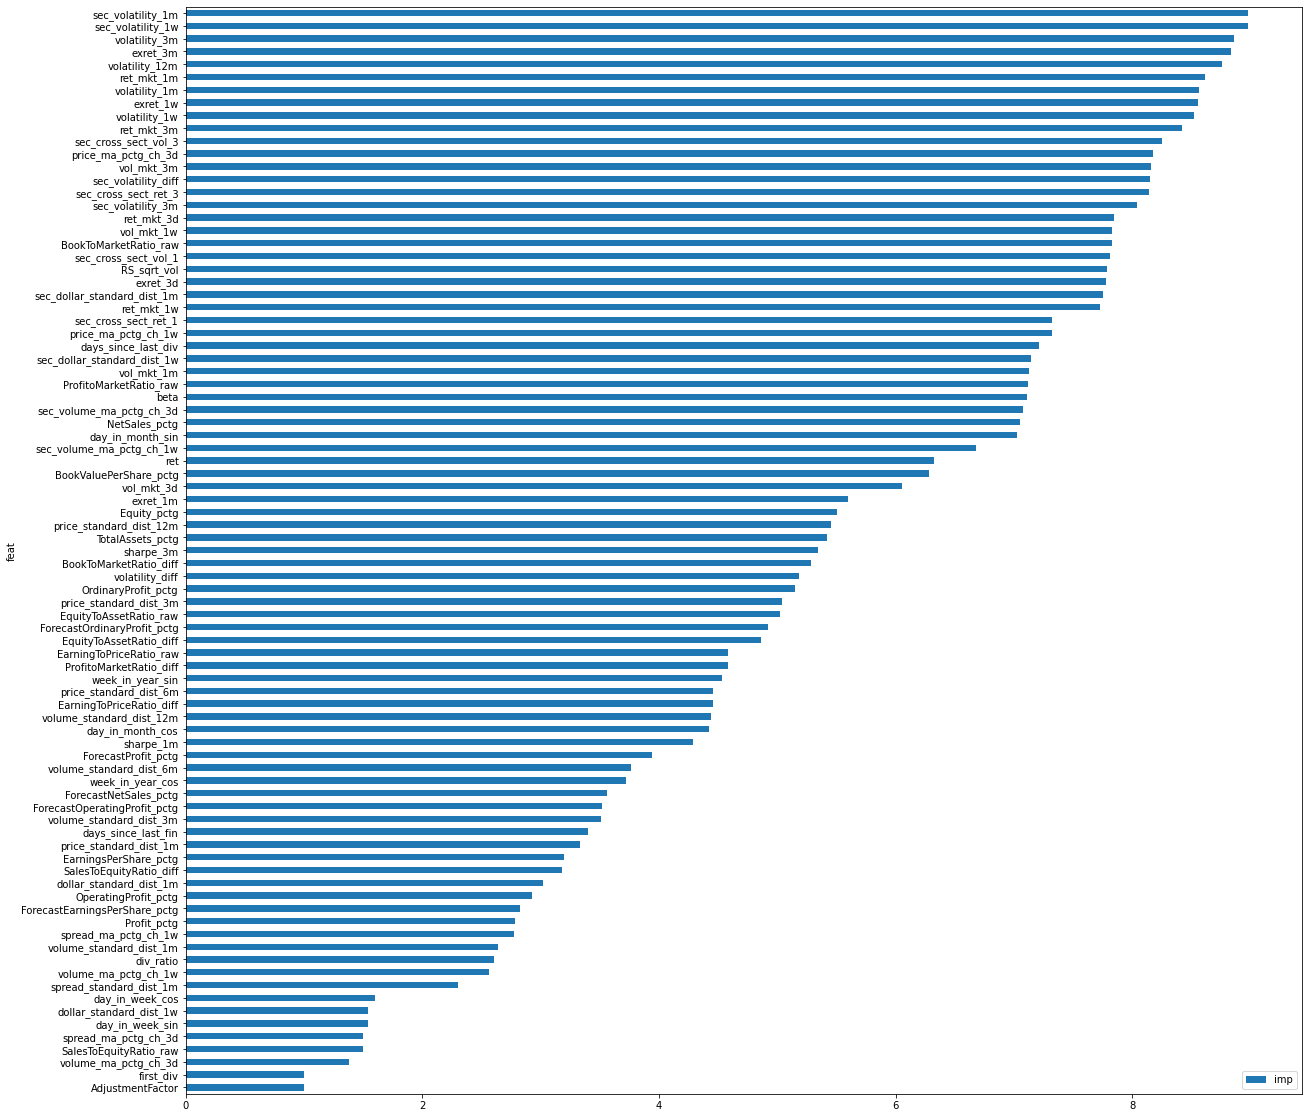

In [13]:
%%time
'''
Feature importance
'''
if RUN_IMP:
    df_imp_agg = run_feature_importance()

In [14]:
%%time
'''
Forward Selection
'''
if RUN_FS:
    
    # normal run
    if FS_SPLIT == None:
        feat_groups = [[x] for x in df_imp_agg.head(N_FEATS_FS).feat]
        fs_hist = forward_selection(base_feats=None, feat_groups=feat_groups, name='')
    
    # FS with splitting stock & market features
    elif FS_SPLIT != None:
        # running both stock & market feats
        if SELECTED_STOCK_FEATS == None:
            # FS for stock features
            feat_groups = [[x] for x in df_imp_agg.loc[lambda x: ~x.feat.isin(time_features)].head(FS_SPLIT['n_stock_feats']).feat]
            fs_hist_stock = forward_selection(base_feats=None, feat_groups=feat_groups, name='stock')
            base_feats = fs_hist_stock.sort_values('score', ascending=True).total_feats.iloc[0].split(', ')
        
        # fixed stock feats and run market feats
        else:
            base_feats = SELECTED_STOCK_FEATS.copy()
        # FS for market features
        feat_groups = [[x] for x in df_imp_agg.loc[lambda x: x.feat.isin(time_features)].head(FS_SPLIT['n_market_feats']).feat]
        fs_hist = forward_selection(base_feats=base_feats, feat_groups=feat_groups, name='market')
        
    # output selected features
    display(fs_hist.sort_values('score', ascending=True).head(1))
    selected_feats = fs_hist.sort_values('score', ascending=True).total_feats.iloc[0].split(', ')

else:
    # if not running both IMP and FS, output pre-set selected_feats
    if not RUN_IMP:
        selected_feats = SELECTED_FEATS
    # if ran IMP but not FS, output first N important features where N is pre-set
    elif RUN_IMP:
        selected_feats = [x[0] for x in feat_groups][:N_FEATS_FINAL]

[2022-07-01 01:16:09] Score: 0.024508700551385716; Num features: 1; Features: volatility_3m
[2022-07-01 01:17:04] Score: 0.04685530072051005; Num features: 1; Features: exret_3m
[2022-07-01 01:17:54] Score: -0.01964717483362665; Num features: 1; Features: volatility_12m
[2022-07-01 01:18:52] Score: -0.020357806547490215; Num features: 1; Features: volatility_1m
[2022-07-01 01:19:50] Score: 0.0246222503522146; Num features: 1; Features: exret_1w
[2022-07-01 01:20:43] Score: 0.02578861726787838; Num features: 1; Features: volatility_1w
[2022-07-01 01:21:33] Score: 0.08308927233334928; Num features: 1; Features: price_ma_pctg_ch_3d
[2022-07-01 01:22:26] Score: -0.02328099001655533; Num features: 1; Features: BookToMarketRatio_raw
[2022-07-01 01:23:21] Score: -0.010467464738320824; Num features: 1; Features: RS_sqrt_vol
[2022-07-01 01:24:16] Score: 0.037832276442103366; Num features: 1; Features: exret_3d
[2022-07-01 01:25:08] Score: 0.10256895961931081; Num features: 1; Features: price_ma

,score,len_feats,total_feats
11,-0.194947,4,"days_since_last_div, ret_mkt_1m, sec_volatility_1w, sec_cross_sect_vol_3"


CPU times: user 5h 39min 54s, sys: 1min 52s, total: 5h 41min 46s
Wall time: 1h 54min 10s


[I 2022-06-30 19:09:23,729] A new study created in memory with name: LGBM optimization
[I 2022-06-30 19:09:54,532] Trial 0 finished with value: -0.19222540634428498 and parameters: {'max_depth': 2, 'num_leaves': 45, 'learning_rate': 0.16835287032389376, 'min_child_weight': 0.003279783466715282, 'subsample': 0.8966786839303624, 'subsample_freq': 2, 'colsample_bytree': 0.6782848870971836, 'reg_alpha': 8.796747740537867, 'reg_lambda': 0.024790413671695443, 'max_bin': 264}. Best is trial 0 with value: -0.19222540634428498.
[I 2022-06-30 19:10:26,432] Trial 1 finished with value: -0.14668309572532903 and parameters: {'max_depth': 2, 'num_leaves': 37, 'learning_rate': 0.07497752073953162, 'min_child_weight': 0.03129221396560016, 'subsample': 0.7634810000951573, 'subsample_freq': 8, 'colsample_bytree': 0.7599142279580525, 'reg_alpha': 0.07582193795356731, 'reg_lambda': 2.6865012969209703, 'max_bin': 239}. Best is trial 0 with value: -0.19222540634428498.
[I 2022-06-30 19:10:57,846] Trial 2 fi

[2022-07-01 07:09:32] {'max_depth': 28, 'num_leaves': 17, 'learning_rate': 0.18313022939660475, 'min_child_weight': 0.005668125371028369, 'subsample': 0.7298902360170945, 'subsample_freq': 6, 'colsample_bytree': 0.9627701100924885, 'reg_alpha': 3.9902808008642325, 'reg_lambda': 0.027914161987410094, 'max_bin': 243}
[2022-07-01 07:09:32] Best score is -0.29684852578083654


<Figure size 432x288 with 0 Axes>

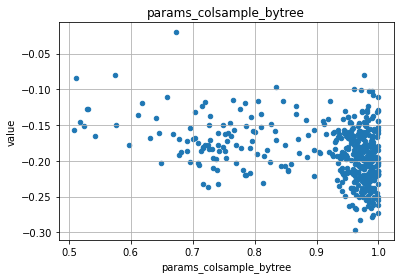

<Figure size 432x288 with 0 Axes>

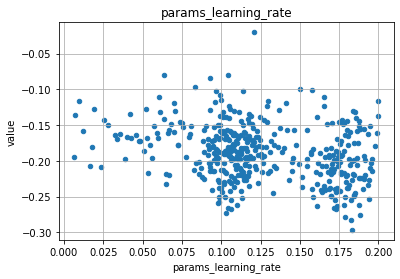

<Figure size 432x288 with 0 Axes>

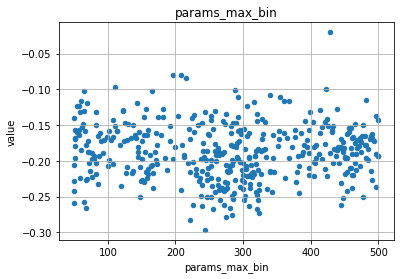

<Figure size 432x288 with 0 Axes>

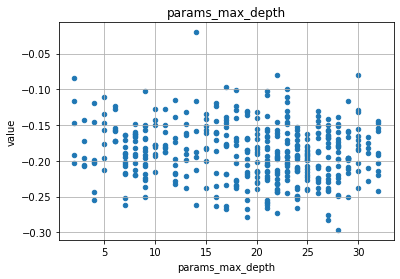

<Figure size 432x288 with 0 Axes>

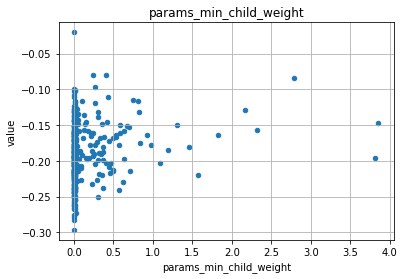

<Figure size 432x288 with 0 Axes>

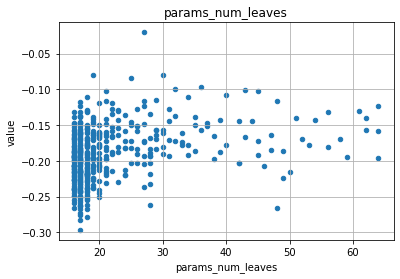

<Figure size 432x288 with 0 Axes>

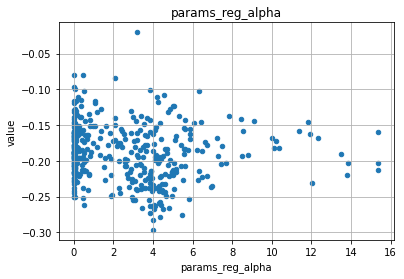

<Figure size 432x288 with 0 Axes>

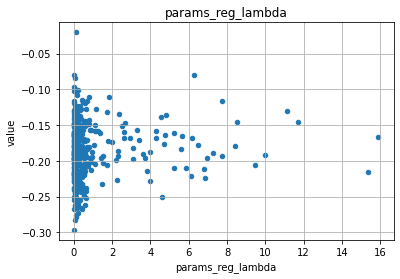

<Figure size 432x288 with 0 Axes>

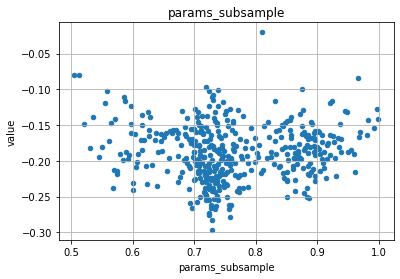

<Figure size 432x288 with 0 Axes>

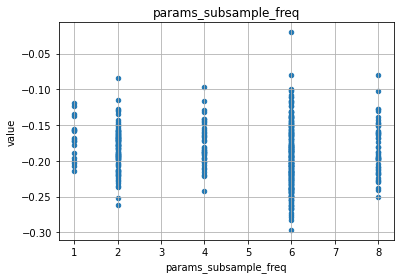

CPU times: user 9h 37min 45s, sys: 4min, total: 9h 41min 45s
Wall time: 4h 11s


In [15]:
%%time
'''
Hyperparameter tuning
'''
if RUN_HP:
    # run optimization
    best_params = optimize_hp()
    
else:
    # if not running HP, use pre-set best parameters
    best_params = BEST_PARAMS

In [16]:
'''
Re-fit best model
'''
params = {'selected_feats': selected_feats, 
          'lgbm_var_params': best_params.copy(), 
          'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
          'n_estimators': N_ESTIMATORS_REFIT, 
          'early_stopping_rounds': EARLY_STOPPING_ROUNDS_REFIT}

outputs = []
for seed in SEEDS:
    SEED = int(seed)
    full_data = full_data.groupby(['fold','trn_val']).sample(frac=1.0, random_state=SEED)
    for fold in range(N_FOLD):
        outputs.append(train_model(fold, params, 'normal'))
    
cv_score = np.mean([x['best_score_'] for x in outputs])
cv_sharpe = np.mean([x['sharpe']['val'] for x in outputs])
log(f"Folds best iterations: {[x['best_iteration_'] for x in outputs]}")
log(f"Folds average num unique values in train: {np.mean([x['n_uniq_trn'] for x in outputs])}")
log(f"Folds average num unique values in validation: {np.mean([x['n_uniq_val'] for x in outputs])}")
log(f"Folds scores: {[x['best_score_'] for x in outputs]}")
log(f"Folds sharpes: {[x['sharpe']['val'] for x in outputs]}")
log(f'Selected Features: {", ".join(selected_feats)}')
log(f'Best params: {str(best_params)}')
log(f'CV score: {cv_score}')
log(f'CV sharpe: {cv_sharpe}')

[2022-07-01 07:15:57] Folds best iterations: [1, 6, 1, 4, 3, 3, 8, 1, 4, 2, 2, 9, 1, 4, 1, 3, 6, 1, 4, 3, 2, 4, 1, 4, 2]
[2022-07-01 07:15:57] Folds average num unique values in train: 10.764666666666665
[2022-07-01 07:15:57] Folds average num unique values in validation: 10.53
[2022-07-01 07:15:57] Folds scores: [1.0983449680419912, 1.0978181110988945, 1.100188159671853, 1.0984646523600232, 1.0983391129252558, 1.0982707936829004, 1.0980021604378645, 1.100231560299425, 1.0984665922410926, 1.0983826072985212, 1.0983300496187933, 1.0979031922280773, 1.1003296916851102, 1.0980117340376434, 1.0984694027638173, 1.0983964949509524, 1.0979825472288063, 1.1003564586982126, 1.0983657586304816, 1.0983861442855882, 1.0984301768241345, 1.098119226542653, 1.1002481942648943, 1.098373757187551, 1.0983398978000316]
[2022-07-01 07:15:57] Folds sharpes: [0.1608962434175309, 0.20997624873925452, 0.37470681854277915, 0.24268173888481825, 0.40525991215269164, 0.22782898533045012, 0.015157052787734333, 0.0

[2022-07-01 07:16:06] Average % in top 200: 0.16596666666666673
[2022-07-01 07:16:06] Average % in bottom 200: 0.24301666666666663
[2022-07-01 07:16:07] Mean long returns: 0.015554798018574196
[2022-07-01 07:16:07] Mean short returns: 0.04919679325471026
[2022-07-01 07:16:07] Mean net returns: 0.06475159127328455
[2022-07-01 07:16:07] Sharpe of long: 0.007440307666245723
[2022-07-01 07:16:07] Sharpe of short: 0.02258060777246807
[2022-07-01 07:16:07] Sharpe of net: 0.06819322014498183
[2022-07-01 07:16:08] Overall sharpe: 0.06819322014498183
[2022-07-01 07:16:08] Last 6m sharpe: 0.11948875143524441
[2022-07-01 07:16:08] Last 3m sharpe: 0.07676886981559468


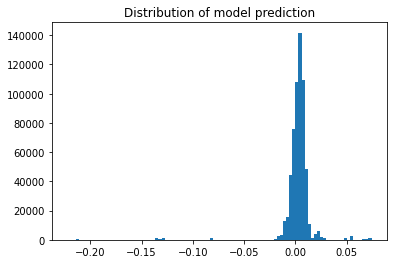

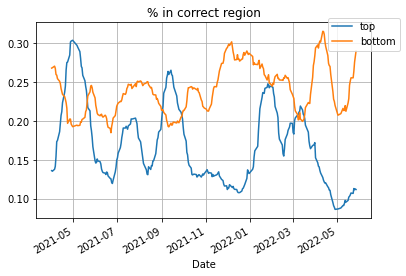

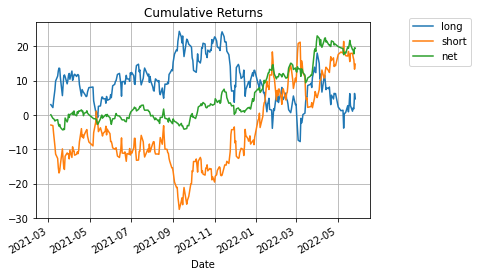

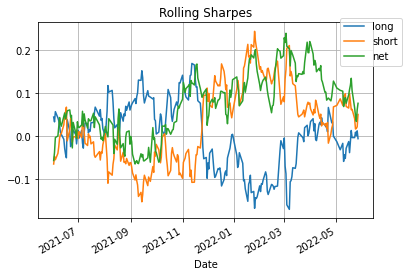

In [17]:
'''
Signal Analysis (before optimization)
'''
if USE_VAL_FULL:
    df_pred_val = pd.concat([x['df_pred_val_full'] for x in outputs]).reset_index(drop=True)
else:
    df_pred_val = pd.concat([x['df_pred_val'] for x in outputs]).reset_index(drop=True)
df_pred_val = df_pred_val.groupby(['RowId','Date','SecuritiesCode']).mean().reset_index()
df_pred_val['Rank'] = df_pred_val.groupby('Date').pred_model.rank(method='first', ascending=False).astype(int) - 1
analyze_signal(df_pred_val)

In [18]:
# signal demean
ret = pd.concat([pd.read_csv(f'{JPX_PATH}/train_files/stock_prices.csv'),
                 pd.read_csv(f'{JPX_PATH}/supplemental_files/stock_prices.csv')]) \
    .sort_values(['Date','SecuritiesCode']) \
    .assign(ret = lambda x: x.groupby('SecuritiesCode').Close.pct_change()) \
    .loc[:, ['Date','SecuritiesCode','ret']] \
    .dropna() \
    .reset_index(drop=True)

def get_stock_clust(ret, date, n_day, stock_list):
    # raw correlation table
    corr = ret.loc[lambda x: pd.to_datetime(x.Date)<=date].pivot(index='Date', columns='SecuritiesCode', values='ret').tail(n_day).corr()
    corr = corr.reindex(index=stock_list, columns=stock_list)
    cols = [c for c in corr if corr[c].notnull().sum()==0]
    corr = corr.drop(cols, axis=0).drop(cols, axis=1)
    stocks = corr.columns.tolist()

    # clustering
    pdist = spc.distance.pdist(corr.values)
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
    stock_corr_clust = pd.DataFrame({'SecuritiesCode':stocks, 'clust':idx}).assign(Date=date).sort_values('clust').reset_index(drop=True)
    return stock_corr_clust

if CLUSTER_DEMEAN:
    df_clust = []
    for date in df_pred_val.Date.unique():
        stock_list = df_pred_val.loc[lambda x: x.Date==date].SecuritiesCode.tolist()
        df_clust.append(get_stock_clust(ret, date, CLUST_N_DAY, stock_list))
    df_clust = pd.concat(df_clust)
    df_pred_val = df_pred_val.merge(df_clust, how='inner', on=['Date','SecuritiesCode'])
    clust_mean = df_pred_val.groupby(['Date','clust']).pred_model.mean().reset_index().rename(columns={'pred_model':'pred_model_mean'})
    df_pred_val = df_pred_val.merge(clust_mean, how='inner', on=['Date','clust'])
    df_pred_val['pred_model_demean'] = df_pred_val.pred_model - df_pred_val.pred_model_mean
    df_pred_val['Rank'] = df_pred_val.groupby('Date').pred_model_demean.rank(method='first', ascending=False).astype(int) - 1
    log(f'Sharpe after demean: {calc_spread_return_sharpe(df_pred_val)}')

# volatility penalty
if VOL_PENALTY:
    std = ret.pivot(index='Date', columns='SecuritiesCode', values='ret') \
        .rolling(VOL_N_DAY).std() \
        .stack().reset_index() \
        .dropna() \
        .rename(columns={0:'std'}) \
        .assign(Date = lambda x: pd.to_datetime(x.Date))
    df_pred_val = df_pred_val.merge(std, how='inner', on=['Date','SecuritiesCode'])
    
    p_result = []
    for p in np.linspace(0,3,20):
        df_pred_val['pred_model_vol_penalty'] = df_pred_val.pred_model_demean / df_pred_val['std'].pow(p)
        df_pred_val['Rank'] = df_pred_val.groupby('Date').pred_model_vol_penalty.rank(method='first', ascending=False).astype(int) - 1
        p_result.append((p, calc_spread_return_sharpe(df_pred_val)))
    p_result = pd.DataFrame(p_result, columns=['p','sharpe']).sort_values('sharpe', ascending=False)
    display(p_result)
    # identify best power and apply
    best_p = p_result.sort_values('sharpe', ascending=False).p.iloc[0]
    df_pred_val.pred_model_vol_penalty = df_pred_val.pred_model_demean / df_pred_val['std'].pow(best_p)
    df_pred_val['Rank'] = df_pred_val.groupby('Date').pred_model_vol_penalty.rank(method='first', ascending=False).astype(int) - 1
    log(f'Sharpe after volatility penalty: {calc_spread_return_sharpe(df_pred_val)}')

[2022-07-01 08:12:02] Sharpe after demean: 0.0008107314547120769


,p,sharpe
8,1.263158,0.117171
13,2.052632,0.114875
12,1.894737,0.114715
11,1.736842,0.114024
10,1.578947,0.113868
7,1.105263,0.113739
9,1.421053,0.113385
16,2.526316,0.113214
14,2.210526,0.112905
15,2.368421,0.112747


[2022-07-01 08:12:25] Sharpe after volatility penalty: 0.11717106897428926


[2022-07-01 08:12:27] Average % in top 200: 0.2051
[2022-07-01 08:12:27] Average % in bottom 200: 0.20613333333333345
[2022-07-01 08:12:28] Mean long returns: 0.058340374020474595
[2022-07-01 08:12:28] Mean short returns: 0.03180717606372588
[2022-07-01 08:12:28] Mean net returns: 0.09014755008420051
[2022-07-01 08:12:28] Sharpe of long: 0.038796118383169785
[2022-07-01 08:12:28] Sharpe of short: 0.019431381242439982
[2022-07-01 08:12:28] Sharpe of net: 0.11717106897428926
[2022-07-01 08:12:29] Overall sharpe: 0.11717106897428926
[2022-07-01 08:12:29] Last 6m sharpe: 0.21521581355300948
[2022-07-01 08:12:29] Last 3m sharpe: 0.262116975756062


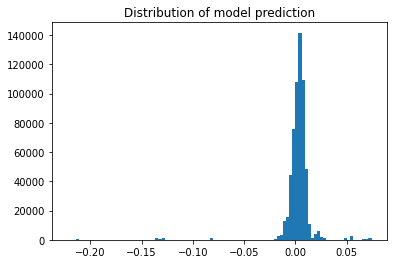

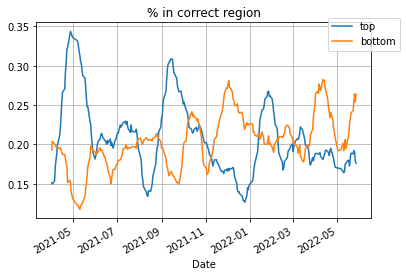

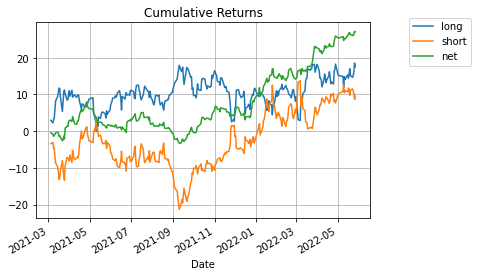

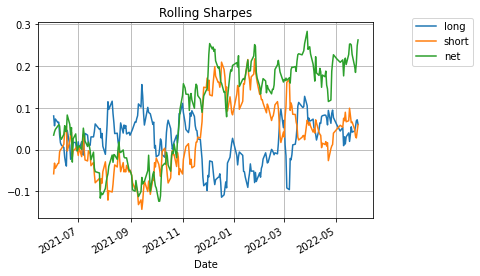

In [19]:
'''
Signal Analysis (after optimization)
'''
analyze_signal(df_pred_val)

In [20]:
# export validation df
df_pred_val.to_feather('df_pred_val')

# Debug